# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 9 — DL Classifiaction on Binary MNIST

---

Submission by:

* FirstName1, Surname1, Matrikelnummer: MatrikelnummerOfFirstTeamMember
* FirstName2, Surname2, Matrikelnummer: MatrikelnummerOfSecondTeamMember



<br style="margin: 20px">

<!-- neutral: #ededf2 -->
<!-- note: #e4eefb -->
<!-- warning: #ffe0e0 -->
<!-- tip: #e4fae4 -->
<div style="padding: 10px; border-radius: 10px; border-style: solid; border-width: thin; background-color: #e4eefb; margin: auto; width: 70%; font-size: 20px; text-align: center">
In the lecture, you have seen how to train a neural network. And in past tutorials, you trained a Gaussian Process on binary <a href="http://yann.lecun.com/exdb/mnist/">MNIST</a>. In this tutorial, we will combine this knowledge to train a neural network on binary MNIST, and inspect some of the results.
<br style="margin: 10px">    
<b>See the <code>Tasks and Evaluation Rules</code> section for more details.</b>
</div>





<hr style="margin: 50px">



 

# Imports and Helpers

In [1]:
# standard imports
import urllib.request  # to download MNIST
import gzip            # to download MNIST
from time import time

# Numerics
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers as jopt
import numpy as np
jax.config.update("jax_enable_x64", True)  # use double-precision numbers
jax.config.update("jax_platform_name", "cpu")  # we don't need GPU here

# Plotting
from matplotlib import pyplot as plt
from tueplots import bundles

plt.rcParams.update({"figure.dpi": 200})
plt.rcParams.update(bundles.beamer_moml())

%config InlineBackend.figure_formats = ["svg"]
%matplotlib inline

In [2]:
def inspect_batch(x_data, y_data, width=1.8, cmap="cividis", title=None):
    """
    Plot all given MNIST images with their corresponding labels.
    :param x_data: Numpy array of images with shape ``(b, h, w)``.
    :param y_data: Numpy array of labels with shape ``(b,)``
    :returns: Figure and axes.
    """
    num_axes = len(x_data)
    assert len(y_data) == num_axes, "Inconsistent inputs!"
    plt.rcParams.update(bundles.beamer_moml(rel_width=width))
    fig, axes = plt.subplots(ncols=num_axes)
    for i, ax in enumerate(axes):
        ax.imshow(x_data[i], cmap=cmap)
        ax.set_title(str(y_data[i]))
        ax.set_xticks([])
        ax.set_yticks([])
    if title is not None:
        fig.suptitle(title)
    return fig, axes

<hr style="margin: 50px">

# Training and Test Data

Since we aim to do binary classification and explore the model confidence, we will focus on two rather similar MNIST handwritten digits: 1 and 7. The following cell contains a convenience class that will allows us to download MNIST, store it persistently, and extract a binarized and standardized version.

In [3]:
class MNIST:
    """
    Static class to download MNIST into numpy arrays and extract a two-digit
    subset.
    """
    BASE_URL = "http://yann.lecun.com/exdb/mnist/"
    X_TRAIN_URL = "train-images-idx3-ubyte.gz"
    Y_TRAIN_URL = "train-labels-idx1-ubyte.gz"
    X_TEST_URL = "t10k-images-idx3-ubyte.gz"
    Y_TEST_URL = "t10k-labels-idx1-ubyte.gz"
    X_SHAPE = (28, 28)

    @classmethod
    def download(cls):
        """
        The MNIST dataset used in this notebook has been downloaded with this
        function. Returns a dict with the following ``np.uint8`` arrays:
        * x_train: (60000, 28, 28), y_train: (60000,)
        * x_test:  (10000, 28, 28), y_test:  (10000,)
        """
        x_train = urllib.request.urlopen(cls.BASE_URL + cls.X_TRAIN_URL).read()
        x_train = gzip.decompress(x_train)
        x_train = np.frombuffer(x_train, np.uint8, offset=16).reshape(
            -1, *cls.X_SHAPE)
        #
        y_train = urllib.request.urlopen(cls.BASE_URL + cls.Y_TRAIN_URL).read()
        y_train = gzip.decompress(y_train)
        y_train = np.frombuffer(y_train, np.uint8, offset=8)
        #
        x_test = urllib.request.urlopen(cls.BASE_URL + cls.X_TEST_URL).read()
        x_test = gzip.decompress(x_test)
        x_test = np.frombuffer(x_test, np.uint8, offset=16).reshape(
            -1, *cls.X_SHAPE)
        #
        y_test = urllib.request.urlopen(cls.BASE_URL + cls.Y_TEST_URL).read()
        y_test = gzip.decompress(y_test)
        y_test = np.frombuffer(y_test, np.uint8, offset=8)
        #
        return {"x_train": x_train, "y_train": y_train,
                "x_test": x_test, "y_test": y_test}

    @classmethod
    def extract_bmnist(cls, mnist, pos_digit=1, neg_digit=7,
                       standardize_imgs=True, dtype=np.float64):
        """
        :param mnist: The output of ``download``
        :param standardize_imgs: If true, returned images will have zero mean
          and unit variance.
        :param dtype: Ideally a large-resolution float.
        :returns: A dictionary that is a subset of the given ``mnist``, but
          only with ``pos_digit`` labeled as 1, and ``neg_digit`` labeled as 0.
        """
        # gather only desired digits, and label them +1, -1
        train_mask = (mnist["y_train"] == pos_digit) | (mnist["y_train"] ==
                                                        neg_digit)
        test_mask = (mnist["y_test"] == pos_digit) | (mnist["y_test"] ==
                                                      neg_digit)
        bmnist = {
            "x_train": mnist["x_train"][train_mask].astype(dtype),
            "y_train": ((mnist["y_train"][train_mask] == POS_DIGIT)).astype(dtype),
            "x_test": mnist["x_test"][test_mask].astype(dtype),
            "y_test": (mnist["y_test"][test_mask] == POS_DIGIT).astype(dtype)}
        # sanity check
        len_x_train, len_y_train = len(bmnist["x_train"]), len(bmnist["y_train"])
        len_x_test, len_y_test = len(bmnist["x_test"]), len(bmnist["y_test"])
        assert len_x_train == len_y_train, "Inconsistent training data in mnist?"
        assert len_x_test == len_y_test, "Inconsistent test data in mnist?"
        # optionally standardize images
        if standardize_imgs:
            bmnist["x_train"] -= bmnist["x_train"].reshape(len_x_train, -1).mean(axis=1)[:, None, None]
            bmnist["x_train"] /= bmnist["x_train"].reshape(len_x_train, -1).std(axis=1)[:, None, None]
            bmnist["x_test"] -= bmnist["x_test"].reshape(len_x_test, -1).mean(axis=1)[:, None, None]
            bmnist["x_test"] /= bmnist["x_test"].reshape(len_x_test, -1).std(axis=1)[:, None, None]
        #
        return bmnist


# Attempt to recover preexisting mnist. If not preexisting, download anew and save
%store -r mnist
try:
    mnist
    print("Fetched MNIST from storage!")
except NameError:
    print("Downloading MNIST...")
    mnist = MNIST.download()
    %store mnist

Fetched MNIST from storage!


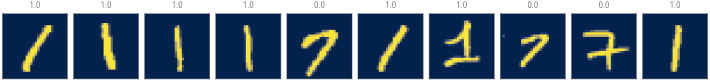

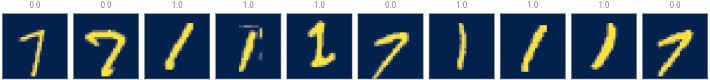

In [4]:
POS_DIGIT, NEG_DIGIT = 1, 7  # feel free to play around with these, but stick to (1, 7) for the submission
DTYPE = np.float64
bmnist = MNIST.extract_bmnist(mnist, POS_DIGIT, NEG_DIGIT, True, DTYPE)

inspect_samples = list(range(0, 10))
inspect_batch(bmnist["x_train"][inspect_samples], 
              bmnist["y_train"][inspect_samples])

inspect_samples = list(range(10, 20))
inspect_batch(bmnist["x_train"][inspect_samples], 
              bmnist["y_train"][inspect_samples]);

<hr style="margin: 50px">

# A Typical Deep Learning Setup:

As seen in the lecture slides, a typical DL training setup features the following components:


* **Dataloader:** Given is a dataset $\mathcal{D} = [(x_i, y_i)]_{i=1}^N$ that maps *inputs* $x_i$ to *ground truth targets* $y_i$. We typically work with random subsets called *batches* $\mathcal{B} \stackrel{iid}{\sim} \mathcal{D}$. A dataloader has the function of providing said batches.
* **Model:** A *neural network* $\hat{y}_i = f(x_i, \theta)$ (with parameters $\theta$), typically composed by many nonlinear, simple, parametrized, and differentiable functions called *layers*. It maps an input $x_i$, to a *predicted* output $\hat{y}_i$.
* **Initializer**: Setting the initial state for the model is also a relevant task. For simpler problems, like this one, it suffices to initialize the weights to small noise. 
* **Objective**: The optimization *objective* in DL typically follows the *Empirical Risk Minimization* paradigm, featuring a *loss function* $\ell$ that penalizes differences between every $(y_i, \hat{y}_i)$ prediction-target pair, coupled with an additive *regularizer* $\rho$ that does not depend on the data. In such cases, the objective $\mathcal{L}$ (also called *loss function*) has the form $\mathcal{L}(\theta) := \frac{1}{B} \sum_{i \in \{\mathcal{B}_1, \dots, \mathcal{B}_B\}} \big\{ \ell(y_i, f(x_i, \theta)) \big\} + \rho(\theta)$. Note how it only depends on the network parameters $\theta$.
* **Optimizer**: The essence of DL training is to modify the weights $\theta$ in order to minimize $\mathcal{L}$, and to do so in a step-wise, batch-wise manner using gradient information (since $f$ is differentiable, we can compute the derivatives of $\mathcal{L}$ with respect to $\theta$, which tell us how to slightly modify $\theta$ in order to reduce $\mathcal{L}$).  The optimizer is simply a component that has access to $\theta$ as well as such derivatives, and can update $\theta$ according to some heuristic (e.g. the *gradient descent* update is $\theta^{(t+1)} := \theta^{(t)} - \eta \nabla_{\theta^{(t)}} \mathcal{L}$ for some *learning rate* $\eta \in \mathbb{R}_{>0}$).

<br style="margin: 10px">
<div style="border-radius: 10px; background-color: #e4eefb; width: 70%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b><code>jax</code> tip:</b></p>
  </div>
<div style="padding: 10px">
One major reason to use software libraries like <code>jax</code> for DL is that they compute the batch gradients automatically; we just need to define the "forward" computations using library components. Another advantage is that DL libraries also provide implementations for popular optimizers.
</div>    
</div>
<br style="margin: 20px">


# Tasks and Evaluation Rules:

In this tutorial, we will adapt the lecture example to MNIST, and analyze some of the obtained results. Specifically, the tasks are:

1. Define a training dataloader that provides `("x_train", "y_train")` batches, randomly drawn from $\mathcal{D}$ without replacement.
2. Define a two-class, ReLU, Multi-Layer Perceptron (like the one from the lecture) that maps MNIST images into a scalar, with dimensionalities `(784, 256, 64, 1)`.
3. Define the objective: Empirical Risk Minimization via cross-entropy loss coupled with *weight decay* (a.k.a. *L2 regularization*).
4. Complete the training and evaluation loop.
5. Once successfully trained, gather and plot the following data samples from the test set:
  * The 5 "positive" examples with largest model output (i.e. clear positives)
  * The 5 "negative" examples with smallest model output (i.e. clear negatives)
  * The 5 "positive" examples with smallest model output (i.e. confusing positives)
  * The 5 "negative" examples with largest model output (i.e. confusing negatives)

<br style="margin: 10px">
<div style="border-radius: 10px; background-color: #ffe0e0; width: 85%;  text-align: left; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>TUTORIAL EVALUATION RULES:</b></p>
  </div>
<div style="padding: 10px">
<ul>
<li>These tasks can be fulfilled with the already imported libraries, and no further libraries should be needed.</li>
<li>The cells below provide some scaffolding code that can be optionally used as a starting point (in which case the docstrings can be used as guidance, and the missing bits are signaled via <code>NotImplemented</code>, <code>NotImplementedError</code> and <code>"TODO"</code>.</li>
<li>The <code>Expected Result</code> cells can be used as a guidance and to showcase correct functionality. In principle, they don't need to be modified, but it is allowed.</li>
<li>Code can be borrowed from the lectures, previous tutorials and other sources but it must be documented via docstrings and/or comments to show sufficient understanding of its interface and functionality (no blind copypaste allowed).</li>
<li>The trained model should surpass an accuracy of 95% after a few seconds on modest hardware.</li>
</ul>
</div>    
</div>
<br style="margin: 10px">



The following hyperparameters allow to achieve that goal on modest hardware (provided as guidance, feel free to modify them):

In [13]:
# HYPERPARAMETERS

# model architecture and initialization
LAYER_SIZES = (784, 256, 64, 1)
INIT_STDDEV = 0.1
CLASSIFICATION_THRESHOLD = 0.5

# optimizer/objective
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-12

# training protocol
NUM_BATCHES = 5000
BATCH_SIZE = 25
RANDOM_SEED = 12345

<hr style="margin: 50px">

# Dataloaders

We provide a definition for the validation dataloader, which runs exactly once over the test subset. In contrast, `train_dataloader` should provide as many batches as desired, re-running over the dataset as many times as needed. For each run over the dataset, retrieved samples should be randomly sampled without replacement, and this randomness should be fully controlled via the random key `rng`: Running twice with same `rng` key should lead to same "random" batches, and different `rng` keys should lead to different "random" batches.

In [16]:
def train_dataloader(bmnist, batch_size=50, rng=jax.random.PRNGKey(12345)):
    """
    Given a binary MNIST dataset, this generator runs infinitely, returning
    randomized batches from the training split.

    :param bmnist: Dictionary as returned by ``MNIST.extract_bmnist``
    :param rng: If a ``jax```random key is given, use it to shuffle
      all entries.
    :yields: An input-output pair of numpy arrays ``(x, y)``, where
      the first dimension of the arrays equals ``batch_size``,
      except for the last batch that may be smaller.
    """
    N, x1, x2 = bmnist["x_train"].shape
    # Euclidean divide the number of training points by the batch size
    num_full_batch, remainder = divmod(N, batch_size)
    while True:
        if rng is None:
            perm = jnp.arange(N)
        else:
            perm = jax.random.permutation(rng, N)
        for i in range(num_full_batch + bool(remainder)):
            idx = perm[batch_size * i : batch_size * (i + 1)]
            yield bmnist["x_train"][idx], bmnist["y_train"][idx]


def test_dataloader(bmnist, batch_size=50):
    """
    Given a binary MNIST dataset, this generator runs once over its
    test split, in batched manner.

    :param bmnist: Dictionary as returned by ``MNIST.extract_bmnist``
    :yields: An input-output pair of numpy arrays ``(x, y)``, where
      the first dimension of the arrays equals ``batch_size``,
      except for the last batch that may be smaller.
    """
    assert batch_size > 0, "batch_size <= 0 not supported"
    for i in range(0, len(bmnist["x_test"]), batch_size):
        x = bmnist["x_test"][i : (i + batch_size), ...]
        y = bmnist["y_test"][i : (i + batch_size), ...]
        yield (x, y)

Let's now inspect our dataloaders:


<br style="margin: 10px">
<div style="border-radius: 10px; background-color: ##e4fae4; width: 80%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>Expected result:</b></p>
  </div>
<div style="padding: 10px">
<b>Running the cell below should plot 2 rows of 10 different random digits from the training set. Each digit should be correctly labeled (positive samples with a 1, negative samples with a 0), and all samples should be different. Using different seeds should lead to different results, whereas repeating seed should lead to same results.</b>
</div>    
</div>
<br style="margin: 20px">

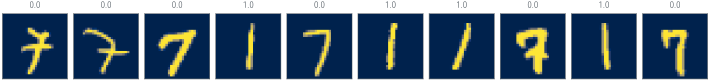

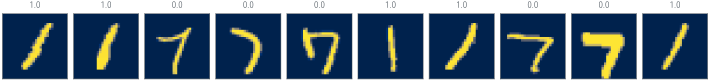

In [17]:
# Create a shuffled training dataloader with RANDOM_SEED and inspect
train_dl = train_dataloader(bmnist, BATCH_SIZE, rng=jax.random.PRNGKey(RANDOM_SEED))
x_batch, y_batch = next(iter(train_dl))
inspect_samples = np.arange(10)
inspect_batch(x_batch[inspect_samples], y_batch[inspect_samples])

# Create a shuffled training dataloader with different seed and inspect
train_dl = train_dataloader(bmnist, BATCH_SIZE, rng=jax.random.PRNGKey(RANDOM_SEED + 1))
x_batch, y_batch = next(iter(train_dl))
inspect_samples = np.arange(10)
inspect_batch(x_batch[inspect_samples], y_batch[inspect_samples]);

<br style="margin: 10px">
<div style="border-radius: 10px; background-color: ##e4fae4; width: 80%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>Expected result:</b></p>
  </div>
<div style="padding: 10px">
<b>Running the cell below should plot a row of 10 digits from the test set. Each digit must also be correctly labeled.</b>
</div>    
</div>
<br style="margin: 20px">

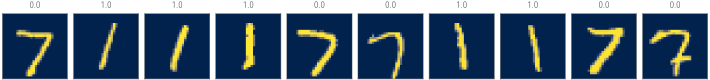

In [18]:
# Create a test dataloader and inspect
test_dl = test_dataloader(bmnist, BATCH_SIZE)
x_batch, y_batch = next(iter(test_dl))
inspect_samples = np.arange(10)
inspect_batch(x_batch[inspect_samples], y_batch[inspect_samples]);

<hr style="margin: 50px">

# Model and Initialization

Define a two-class Multi-Layer Perceptron (like the one from the lecture) that maps MNIST images into a scalar, with dimensionalities `(784, 256, 64, 1)`. This means that it featuers 3 layers: one mapping from 784 dimensions to 256, and so on. Each $i^{th}$ layer contains 2 parameters: a weight and a bias $[w_i, b_i]$, such that $x_{out} = \sigma(w^T x_{in}) + bias)$, where $\sigma$ is a nonlinearity (in our case ReLU).

It should be using `jax`, in order to leverage automatic differentiation and batching.

<br style="margin: 10px">
<div style="border-radius: 10px; background-color: #e4eefb; width: 85%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b><code>jax</code> tip:</b></p>
  </div>
<div style="padding: 10px">
Unlike other popular DL frameworks, <a href="https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions"><code>jax</code> follows a strictly functional paradigm</a>, most notably meaning that the main building blocks are functions without state or side effects. Such functions expect all the input data to be passed through the (also stateless) function parameters, and all the results to be retrieved through the function results. A pure function will always return the same result if invoked with the same inputs. Not following this paradigm (e.g. by passing stateful computations to jax functions) is generally undefined and can lead to <a href="https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html#just-in-time-compilation-with-jax">undesired behaviour</a>. For us, this means that we will be writing functions that typically accept multiple inputs and outputs, and the "state" (e.g. current parameter values) will be stored in variables outside of those functions.
</div>    
</div>
<br style="margin: 20px">



In [19]:
def mlp(params, inputs, nonlinearity=jax.nn.relu):
    """
    Computes the forward pass of an MLP, defined using JAX components. Note that
    it returns the *logits*. To map logits into predicted scores, a sigmoid
    function can be applied.

    :param params: List of pairs in the form ``[(w1, b1), (w2, b2), ...]`` where
      ``w_i, b_i`` are the weights and biases for layer ``i``, such that a layer
      computes ``outputs = nonlinearity((w_i @ inputs) + b_i)``.
    :param inputs: Batch of flattened input images with shape ``(batch, in_shape)``
    :returns: A vector of shape ``(batch,)``, containing one logit per input that
      should predict the corresponding binary class.
    """
    activations = inputs
    for w, b in params[:-1]:
        outputs = jnp.dot(activations, w) + b
        activations = jax.nn.relu(outputs)

    final_w, final_b = params[-1]
    logits = jnp.dot(activations, final_w) + final_b
    return logits[..., 0]   


def create_mlp_params(layer_sizes, stddev=0.1, rng=jax.random.PRNGKey(12345)):
    """
    Creates MLP parameters of given sizes and initializes them with Gaussian
    noise of zero mean and given standard deviation.
    :param layer_sizes: List of integers in the form ``[d1, d2, ...]``,
      where each MLP layer maps from ``d_i`` dimensions to ``d_{i+1}``.
    :param stddev: Standard deviation of the initial Gaussian noise.
    :param rng: ``jax.random.PRNGKey`` to draw noise from.
    """
    params = []
    for m, n in zip(layer_sizes[:-1], layer_sizes[1:]):
        rng, rng_b = jax.random.split(rng)
        w = jax.random.normal(rng, (m, n)) * stddev
        b = jax.random.normal(rng_b, (n,)) * stddev
        params.append((w, b))
    return params


def test_predictions(params, bmnist, batch_size=50, threshold=0.5):
    """
    Helper function to run ``sigmoid(model)`` over the whole test subset
    and compute the accuracy.

    :param threshold: Any sigmoid outputs above this number will be consider
      positive (i.e. a value of 1), otherwise negative (i.e. a value of 0).
    :param bmnist: See ``test_dataloader``.
    :param batch_size: See ``test_dataloader``.
    :returns: The triple ``(accuracy, logits, targets)``, where
      ``accuracy`` is the ratio of correctly classified samples, ``logits``
      are the predicted logits following the order provided by
      ``test_dataloader``, and ``targets`` are the corresponding ground
      truth annotations.
    """
    all_logits = []
    targets = []
    for x_batch, y_batch in test_dataloader(bmnist, batch_size):
        logits = mlp(params, x_batch.reshape(len(x_batch), -1))
        all_logits.extend(list(logits))
        targets.extend(list(y_batch))
    #
    predictions = jax.nn.sigmoid(np.array(all_logits)) > threshold
    targets = np.array(targets)
    accuracy = (predictions == targets).sum() / len(predictions)
    return accuracy, all_logits, targets

Let's inspect the model outputs when forward propagating through some samples.

<br style="margin: 10px">
<div style="border-radius: 10px; background-color: ##e4fae4; width: 80%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>Expected result:</b></p>
  </div>
<div style="padding: 10px">
<b>Running the cell below should plot the same row of 10 digits from the test set as before (since the test dataloader is not random), but this time each digit is labeled with a noisy logit returned by the initialized (but not yet trained) MLP. Furthermore, a histogram of the accuracy over the whole test set should be plotted for 100 different random initializations, and the resulting distribution should be bell-shaped and centered around 50%.</b>
</div>    
</div>
<br style="margin: 20px">

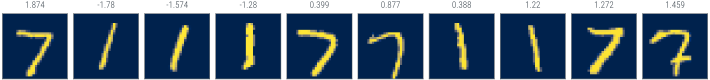

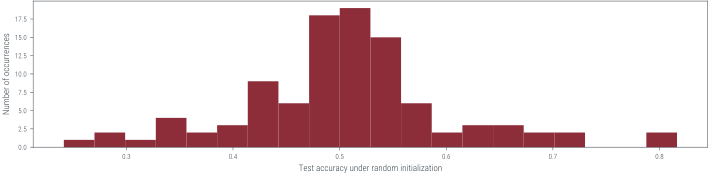

In [20]:
# create test dataloader
test_dl = test_dataloader(bmnist, BATCH_SIZE)
x_batch, y_batch = next(iter(test_dl))
# instantiate model
mlp_params = create_mlp_params(LAYER_SIZES, INIT_STDDEV, 
                               jax.random.PRNGKey(RANDOM_SEED))
# forward pass
predictions = mlp(mlp_params, x_batch.reshape(BATCH_SIZE, -1))
# plot 10 samples with their random logits
inspect_samples = np.arange(10)
inspect_batch(x_batch[inspect_samples], 
              predictions[inspect_samples].round(decimals=3))

# compute test accuracy for 100 different random initializations
accuracies = []
for i in range(100):
    mlpp = create_mlp_params(LAYER_SIZES, INIT_STDDEV, jax.random.PRNGKey(RANDOM_SEED + i))
    acc, _, _ = test_predictions(mlpp, bmnist, BATCH_SIZE, CLASSIFICATION_THRESHOLD)
    accuracies.append(acc)
# plot histogram of accuracies
fig, ax = plt.subplots()
ax.hist(accuracies, bins=20)
ax.set_ylabel("Number of occurrences")
ax.set_xlabel("Test accuracy under random initialization");

<hr style="margin: 50px">

# Objective and Evaluation Metrics

In order to train the model using gradients, we must define the objective. Recall the formulation:

$\mathcal{L}(\theta) := \frac{1}{B} \sum_{i \in \{\mathcal{B}_1, \dots, \mathcal{B}_B\}} \big\{ \ell(y_i, f(x_i, \theta)) \big\} + \rho(\theta)$

Here, the objective is the same as in the lecture: $\ell$ is the binary cross-entropy, and $\rho$ is the L2 regularizer on all MLP parameters. Remember that `jax` follows a functional paradigm, where all relevant inputs and outputs must be stated explicitly and all side effects are kept outside of the functions.

In [ ]:
def loss_fn(params, inputs, targets, l2_reg=0.0):
    """
    :param params: Network parameters. See ``mlp`` docstring.
    :param inputs: Batch of network inputs. See ``mlp`` docstring.
    :param targets: Batch of ground truth annotations corresponding to ``inputs``,
      as provided by the dataloader.
    :param l2_reg: Strength of the L2 regularization term, such that
      ``result = cross_entropy + (0.5 * l2_reg * l2norm(params)**2)``.
    :returns: A single scalar representing the empirical risk plus the L2 
      regularizer over the given batch, with respect to the given parameters.
    """
    

Let's re-run again the first test batch through the model, but this time we gather the loss and gradients.


<br style="margin: 10px">
<div style="border-radius: 10px; background-color: ##e4fae4; width: 80%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>Expected result:</b></p>
  </div>
<div style="padding: 10px">
<b>Running the cell below should plot one image per MLP weight matrix, containing the corresponding gradients (which are also matrices of same shape). The loss value displayed at the top should be a positive float.</b>
</div>    
</div>
<br style="margin: 20px">

In [ ]:
# create test dataloader
test_dl = test_dataloader(bmnist, BATCH_SIZE)
x_batch, y_batch = next(iter(test_dl))

# instantiate model and forward+backward pass
mlp_params = create_mlp_params(LAYER_SIZES, INIT_STDDEV, 
                               jax.random.PRNGKey(RANDOM_SEED))
loss, grads = jax.value_and_grad(loss_fn)(mlp_params, x_batch.reshape(BATCH_SIZE, -1), 
                                           y_batch, WEIGHT_DECAY)

# plot weight gradients and loss
plt.rcParams.update(bundles.beamer_moml(rel_width=1.8, rel_height=1.8))
fig, axes = plt.subplots(nrows=len(grads))
fig.suptitle(loss)
for i, ax in enumerate(axes):
    wg = grads[i][0].T
    absmax = abs(wg).max()
    ax.imshow(wg, cmap="bwr", aspect="auto", vmin=-absmax, vmax=absmax)

<hr style="margin: 50px">

# Training Loop

We can finally put all pieces together to train the neural network. The only missing step is to actually update the parameters $\theta$ using the gradient information. This is the role of the optimizer (more info [here](https://jax.readthedocs.io/en/latest/jax.example_libraries.optimizers.html)). In point `#3` of the cell below, we showcase how this is normally handled using `jax`. Note that we depart slightly from the functional paradigm:

<br style="margin: 3px">
<div style="border-radius: 10px; background-color: #e4eefb; width: 85%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b><code>jax</code> tip:</b></p>
  </div>
<div style="padding: 10px">
For the optimization step, <code>jax</code>  takes a notable exception from the functional paradigm via the so-called <a href="https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html">Just-In-Time (JIT) compilation</a>. The idea is that, if we have a function that is expensive to run but has a "fixed" structure, we can speed up its computation substantially by allowing the JIT compiler to create an optimized version of it. The downside is that we lose flexibility: not everything can be JIT-compiled (e.g. `if-else` branching is generally not allowed), and some of the elements used get "frozen" during compilation, meaning <i>the function becomes stateful</i> (i.e. changing some Python variables after compilation won't alter the behaviour of already-compiled functions, which can cause some confusion).
</div>    
</div>
<br style="margin: 3px">

For us, this means mostly two things:

1. The most expensive operations during DL training are typically the forward and backward comptuation, as well as the parameter update. We would like to bundle those into a single `update` function and and JIT-compile it.
2. But this function would basically depend on all other components. For this reason it needs to be defined right before the training loop starts. Also, it can not contain any dynamic structure like if-else branches.


<br style="margin: 10px">
<div style="border-radius: 10px; background-color: ##e4fae4; width: 80%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>Expected result:</b></p>
  </div>
<div style="padding: 10px">
<b>Running the cell below should initialize and train our MLP for <code>NUM_BATCHES</code> and converge to less than 0.1 loss and over 90% accuracy after a few seconds. As training progresses, loss should generally decrease and accuracy increase.</b>
</div>    
</div>
<br style="margin: 20px">

In [ ]:
# 1. Dataloaders
train_dl = train_dataloader(bmnist, BATCH_SIZE, rng=jax.random.PRNGKey(RANDOM_SEED))
test_dl = test_dataloader(bmnist, BATCH_SIZE)

# 2. Model params
mlp_params = create_mlp_params(LAYER_SIZES, INIT_STDDEV, 
                               jax.random.PRNGKey(RANDOM_SEED))

# 3. Optimizer and JIT update step
opt_init, opt_update, get_params = jopt.sgd(LEARNING_RATE)
opt_state = opt_init(mlp_params)

@jax.jit
def update(step, opt_state, inputs, targets, l2_reg=0.0):
    """
    In order to speed up computations (not really necessary for small
    examples like this one, but crucial for larger DL setups), we 
    "bundle" the forwardprop, backprop and update steps into a single
    JIT-able function.
    """
    value, grads = jax.value_and_grad(loss_fn)(get_params(opt_state), 
                                               inputs, targets, l2_reg)
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state


# Training loop
losses, test_accs = [], []  # we will gather losses and accuracies
t0 = time()
#
for batch_t, (x_batch, y_batch) in enumerate(train_dl, 1):
    if batch_t > NUM_BATCHES:
        break
        
    # TODO: compute forwardprop, backprop and update step
    loss = NotImplemented
    
    losses.append(loss)
    if batch_t % 200 == 0:
        
        # TODO: run model on test set and gather accuracy
        test_acc = NotImplemented
        
        print(f"[step {batch_t:07d}] Loss={loss:5f}, Test accuracy={test_acc:2f}")
        test_accs.append((batch_t, test_acc))
#
print("Elapsed seconds:", time() - t0)


plt.rcParams.update(bundles.beamer_moml(rel_width=1.8, rel_height=1.5))
fig, (ax_loss, ax_acc) = plt.subplots(nrows=2)
#
ax_loss.plot(range(NUM_BATCHES), losses)
ax_loss.set_title("Loss")
#
ax_acc.plot(*zip(*test_accs))
_ = ax_acc.set_title("Test Accuracy")

<hr style="margin: 50px">

# Inspect Trained Results


Once successfully trained, gather and plot the following data samples from the test set:

* The 5 "positive" examples with largest model output (i.e. clear positives)
* The 5 "negative" examples with smallest model output (i.e. clear negatives)
* The 5 "positive" examples with smallest model output (i.e. confusing positives)
* The 5 "negative" examples with largest model output (i.e. confusing negatives)

In [ ]:
# Gather all required data
test_acc, logits, targets = test_predictions(
    get_params(opt_state), bmnist, BATCH_SIZE, CLASSIFICATION_THRESHOLD)
predictions = np.asarray(jax.nn.sigmoid(np.array(logits)))
assert test_acc > 0.9, "Low accuracy! Has the model been correctly trained?"


def retrieve_interesting_samples(predictions, targets, num_samples=5):
    """
    :param predictions: Numpy array of ``sigmoid(mlp(x_i))`` floats. 
    :param targets: Numpy array of ground truth scalars ``y_i`` given in
      same order as predictions.
    :returns: A dictionary ``{"posmax": [idx1, idx2, ...], "posmin": [...],
      "negmax": [...], "negmin": [...]}`` with the indexes for the N
      labeled "positive" examples with largest prediction, the N "positive"
      examples with smallest model output, the N "negative" examples with
      largest model output and the N "negative" examples with smallest model
      output, where N is ``num_samples``.
    """
    raise NotImplementedError("TODO")

<br style="margin: 10px">
<div style="border-radius: 10px; background-color: ##e4fae4; width: 80%;  text-align: center; margin: auto;">
  <div style="background: rgba(0, 0, 0, 0.05); border-style: solid; border-width: thin; border-radius: 10px; filter: brightness(0.9); padding: 10px; "><p style=""><b>Expected result:</b></p>
  </div>
<div style="padding: 10px">
<b>Running the cell below should gather indexes for the 4 interesting groups of test samples, as described above. Then, each group should be plotted in its own row, where each row contains all samples of the same class. The "clear" rows should depict instances that are clearly identifiable, whereas the "confusing" rows should depict examples that present some irregularities.</b>
</div>    
</div>
<br style="margin: 20px">

In [ ]:
# gather interesting samples
interesting = retrieve_interesting_samples(predictions, targets, 5)

# Plot "clear" examples
inspect_batch(bmnist["x_test"][interesting["posmax"]], predictions[interesting["posmax"]],
              title="Clear positives")

inspect_batch(bmnist["x_test"][interesting["negmin"]], predictions[interesting["negmin"]],
              title="Clear negatives")

# Plot "confusing" examples
inspect_batch(bmnist["x_test"][interesting["posmin"]], predictions[interesting["posmin"]],
              title="Confusing positives")

inspect_batch(bmnist["x_test"][interesting["negmax"]], predictions[interesting["negmax"]],
              title="Confusing negatives");


End of `Exercise Sheet No. 9 — DL Classifiaction on Binary MNIST`.